# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os,datetime, random
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
np.set_printoptions(threshold=2000)
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
dir_loc = 'C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data'

In [5]:
#train_doc = np.random.permutation(open('C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//train_aug_balanced.csv').readlines())
train_doc = np.random.permutation(open(dir_loc + '//train_bal.csv').readlines())
val_doc = np.random.permutation(open(dir_loc + '//val.csv').readlines())
source_path = dir_loc + '//train_bal'
val_path = dir_loc + '//val'

batch_size = 30

# Num
train_doc.shape[0]

1150

In [6]:
# Image Resolution
width, height, channels = 80, 80, 3

In [7]:
# Each video comprises 30 frames
# Looking at videos, first and last five frames seems to not add much value
# so, will feed all frames from 5th to 25th
start_frame, end_frame, skip_frame = 0, 29, 1

In [8]:
num_images_per_video = (end_frame - start_frame + 1)//skip_frame
num_images_per_video

30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
# Image Transformations
# Apply one of the rotation or horizontal or vertical shift
# These transformations will be applied randomly to only 50% of sequences 
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2)

def preprocess_img(img, mode = 'train'):
    if mode == 'train':
        img = datagen.random_transform(img)
    return img

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(start_frame, num_images_per_video, skip_frame)   # Using every second image instead of all
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = t.shape[0]//batch_size# calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
       
            x, y, z = len(img_idx), width, height
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            # Creating variation in sequences through transformations
            # Idea is to transform all images in 50% of videos in one batch
            # the transformations will either of the three
            # rotation - 10%,
            # height, width shift by 20%
            
            transform_idxs = random.sample(list(np.arange(batch_size)), int(0.5*batch_size))

            for folder in range(batch_size): # iterate over the batch_size
                # Each data folder will beread and all images will 
                # sorted based on timestamp
                # While images may already be in sequence but for offline
                # transformation applied to create augmented data it will
                # be better to sort based on timestamp.

                imgs_fullpath = sorted(Path(source_path +'//'+ 
                                            t[folder + (batch*batch_size)].split(';')[0]
                                           ).iterdir(),
                                       key=lambda f: f.stat().st_mtime)
                # imgs will contain list of all images in a video
                imgs = [os.path.split(x)[-1] for x in imgs_fullpath] 


                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'//'+
                                   t[folder + (batch*batch_size)].strip().split(';')[0]+
                                   '//'+imgs[item]).astype(np.float32)


                    # Crop only those images where height and width mismatches
#                     if image.shape[0] != image.shape[1]:
#                         image = image[:, 20:140]

                    # Resize images to chosen resolution
                    image_resolution = image.shape
        
                    if image_resolution != (width, height):
                         image = imresize(image, (width, height))
                    
                    # images will be transformed only during training mode
                    if folder in transform_idxs:
                        image = preprocess_img(image, mode='train')                    

#                     if image.shape[0] != width and image.shape[1] != 80:
#                         image = imresize(image, (80, 80))

                    # Since these are videos comprising n atural images we will
                    # normalize by diving each pixel with maximum value                 
#                     batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
#                     batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
#                     batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0

                    min_p = np.percentile(image,5)
                    max_p = np.percentile(image,95)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - min_p)/(max_p - min_p)
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - min_p)/(max_p - min_p)
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - min_p)/(max_p - min_p)
                    

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             print('Batch #####', batch )
#             print('batch_data.shape = ', batch_data.shape)
#             print('batch_labels.shape = ', batch_labels.shape)

#             print('batch_data ##### ')
#             print(batch_data)
#             print('\n')

#             print('batch_labels -----')
#             print(batch_labels)
#             print('\n')
               
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches           
        rem_batch_size = t.shape[0] % batch_size
        if (rem_batch_size > 0):           

            batch = num_batches 

            transform_idxs = random.sample(list(np.arange(batch_size)), int(0.5*batch_size))

            for folder in range(rem_batch_size): # iterate over the batch_size
                imgs_fullpath = sorted(Path(source_path +'//'+ t[folder + (batch*batch_size)].split(';')[0]).iterdir(), key=lambda f: f.stat().st_mtime)
                imgs = [os.path.split(x)[-1] for x in imgs_fullpath] 

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'//'+ 
                                   t[folder + (batch*batch_size)].strip().split(';')[0]+
                                   '//'+imgs[item]).astype(np.float32)

#                     if image.shape[0] != image.shape[1]:
#                         image = image[:, 20:140]
                    # Resize images to chosen resolution
                    image_resolution = image.shape
        
                    if image_resolution != (width, height):
                         image = imresize(image, (width, height))

                    if folder in transform_idxs:
                        image = preprocess_img(image, mode = 'train')

#                     batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
#                     batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
#                     batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0
                    min_p = np.percentile(image,5)
                    max_p = np.percentile(image,95)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - min_p)/(max_p - min_p)
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - min_p)/(max_p - min_p)
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - min_p)/(max_p - min_p)
                    
                batch_labels[folder, int(t[folder + (batch*rem_batch_size)].strip().split(';')[2])] = 1
            
#             print('Batch #####', batch )
#             print('batch_data.shape = ', batch_data.shape)
#             print('batch_labels.shape = ', batch_labels.shape)

#             print('batch_data ##### ')
#             print(batch_data)
#             print('\n')

#             print('batch_labels -----')
#             print(batch_labels)
#             print('\n')
            
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
# Lets choose subset, 20%, of videos for ablation run
train_path = source_path
validation_path = val_path

ablation_ratio = 0.3 
skip = int(ablation_ratio * 100)
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc[::])
num_val_sequences = len(val_doc[::])   
epochs = 100 

print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
print('# Epochs =', epochs)
    

# training sequences = 1150
# validation sequences = 100
# Epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from keras import optimizers

In [13]:
model = Sequential()
num_classes = 5

input_shape = (num_images_per_video, width, height, channels)
print(input_shape)

#input_shape = (15, 80, 80,3)

model.add(Conv3D(4, (2,2,2), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

#model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(8, (2,2,2), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

(30, 80, 80, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 80, 80, 4)     100       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 80, 80, 4)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 80, 80, 4)     16        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 80, 80, 8)     264       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 80, 80, 8)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 80, 80, 8)     32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 40, 40, 8)     0    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
# abltaion run
# epochs = 1
# training, validation sequences = 5%

#Let's try only on 5% of sequences, batch_size = 30, num_epochs = 10
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
print('# Epochs =', epochs)

# batch_size = 80

# if num_train_sequences < 50:
#     batch_size_train = num_train_sequences
# else:
#     batch_size_train = batch_size

train_generator = generator(train_path, 
                            train_doc[:num_train_sequences],
                            batch_size)  
val_generator = generator(val_path,
                          val_doc[:num_val_sequences],
                          batch_size)

# Let's generate the validation data
#val_data = next(val_generator)

# training sequences = 1150
# validation sequences = 100
# Epochs = 100


In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


print("number of Epochs = ", epochs)
print("steps_per_epoch = ", steps_per_epoch)
print("validation_steps = ", validation_steps)    

number of Epochs =  100
steps_per_epoch =  39
validation_steps =  4


In [16]:
#sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
optimiser = optimizers.SGD(lr=0.01, clipnorm=1.0, nesterov=True)

model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 80, 80, 4)     100       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 80, 80, 4)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 80, 80, 4)     16        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 80, 80, 8)     264       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 80, 80, 8)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 80, 80, 8)     32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 40, 40, 8)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
class Plot_losses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []        
        
        self.fig = plt.figure(figsize=(4, 4))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)

        # Plot Loss        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        #print(self.i, "--",len(self.losses),"--", self.losses )
               
        #self.fig.add_subplot(1,1,1)
        #clear_output(wait=True)

        if len(self.losses) > 1:
            plt.plot(self.x, self.losses, label="loss")
            plt.plot(self.x, self.val_losses, label="val_loss")
            plt.legend()
            plt.show();                      
        
        self.i += 1
    
plot_losses = Plot_losses()

In [18]:
model_name = dir_loc + '//models//model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '//'
print(model_name) 

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.001)
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

callbacks_list = [checkpoint, LR, plot_losses ] #, valid_metrics, early_stopping]

C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//
C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
class_count = {'0':0,'1':0,'2':0,'3':0,'4':0}

for folder in range(len(train_doc)):
    #print(train_doc[folder])
    cls = int(train_doc[folder].split(';')[2])
    # Let's count the sequences in each class
    if cls == 0:
        class_count['0'] = class_count.get('0') + 1
    elif cls == 1:
        class_count['1'] = class_count.get('1') + 1
    elif cls == 2:
        class_count['2'] = class_count.get('2') + 1         
    elif cls == 3:
        class_count['3'] = class_count.get('3') + 1
    elif cls == 4:
        class_count['4'] = class_count.get('4') + 1

print("class_count ", class_count)
print("total count ", sum(class_count.values()))
class_weight = [round(v / total, 2) for total in (sum(class_count.values()),) for k, v in class_count.items()]
print('class_weight', class_weight)


class_count  {'0': 230, '1': 230, '2': 230, '3': 230, '4': 230}
total count  1150
class_weight [0.2, 0.2, 0.2, 0.2, 0.2]


Epoch 1/100
Source path =  Source path =  C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//train_bal ; batch size = 30
C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//val ; batch size = 30
39/39 [==============================] - 201s 5s/step - loss: 2.8269 - categorical_accuracy: 0.2359 - val_loss: 1.7643 - val_categorical_accuracy: 0.3833

Epoch 00001: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00001-2.82685-0.23590-1.76430-0.38333.h5
Epoch 2/100
39/39 [==============================] - 191s 5s/step - loss: 1.8186 - categorical_accuracy: 0.3026 - val_loss: 1.6694 - val_categorical_accuracy: 0.3667

Epoch 00002: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00002-1.81862-0.30256-1.66940-0.36667.h5


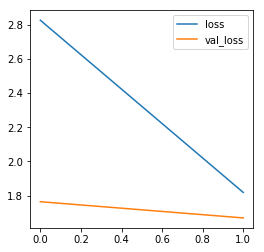

Epoch 3/100
39/39 [==============================] - 194s 5s/step - loss: 1.5706 - categorical_accuracy: 0.3385 - val_loss: 1.6747 - val_categorical_accuracy: 0.3333

Epoch 00003: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00003-1.57061-0.33846-1.67469-0.33333.h5


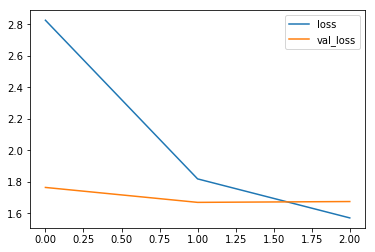

Epoch 4/100
39/39 [==============================] - 193s 5s/step - loss: 1.4038 - categorical_accuracy: 0.4231 - val_loss: 1.7473 - val_categorical_accuracy: 0.4250

Epoch 00004: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00004-1.40379-0.42308-1.74730-0.42500.h5


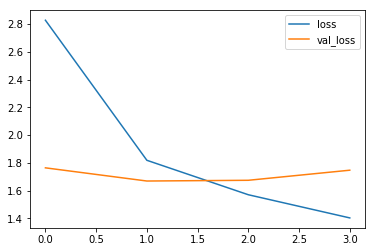

Epoch 5/100
39/39 [==============================] - 193s 5s/step - loss: 1.3255 - categorical_accuracy: 0.4675 - val_loss: 1.7984 - val_categorical_accuracy: 0.3667

Epoch 00005: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00005-1.32547-0.46752-1.79839-0.36667.h5


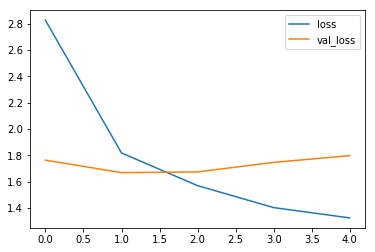

Epoch 6/100
39/39 [==============================] - 193s 5s/step - loss: 1.2443 - categorical_accuracy: 0.4906 - val_loss: 1.6995 - val_categorical_accuracy: 0.4000

Epoch 00006: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00006-1.24431-0.49060-1.69953-0.40000.h5


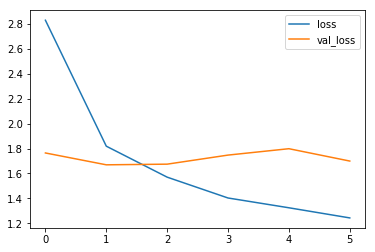

Epoch 7/100
39/39 [==============================] - 194s 5s/step - loss: 1.2044 - categorical_accuracy: 0.5077 - val_loss: 1.6198 - val_categorical_accuracy: 0.4833

Epoch 00007: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00007-1.20444-0.50769-1.61980-0.48333.h5


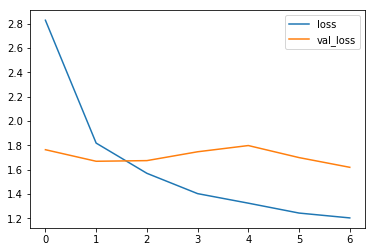

Epoch 8/100
39/39 [==============================] - 193s 5s/step - loss: 1.1355 - categorical_accuracy: 0.5513 - val_loss: 1.8341 - val_categorical_accuracy: 0.4417

Epoch 00008: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00008-1.13548-0.55128-1.83415-0.44167.h5


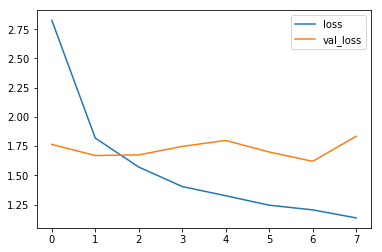

Epoch 9/100
39/39 [==============================] - 194s 5s/step - loss: 1.1095 - categorical_accuracy: 0.5393 - val_loss: 1.6184 - val_categorical_accuracy: 0.5500

Epoch 00009: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00009-1.10950-0.53932-1.61843-0.55000.h5


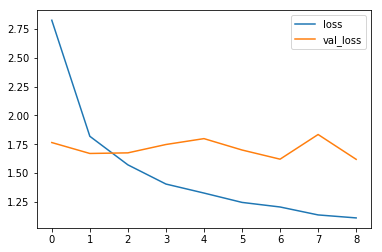

Epoch 10/100
39/39 [==============================] - 194s 5s/step - loss: 1.0811 - categorical_accuracy: 0.5983 - val_loss: 1.6548 - val_categorical_accuracy: 0.4000

Epoch 00010: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00010-1.08110-0.59829-1.65478-0.40000.h5


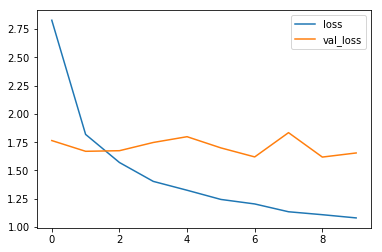

Epoch 11/100
39/39 [==============================] - 193s 5s/step - loss: 1.0825 - categorical_accuracy: 0.5812 - val_loss: 1.6454 - val_categorical_accuracy: 0.5083

Epoch 00011: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00011-1.08254-0.58120-1.64536-0.50833.h5


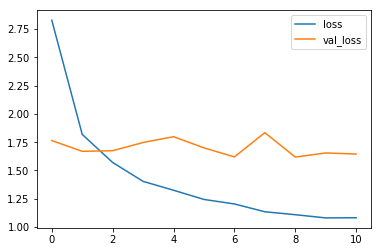

Epoch 12/100
39/39 [==============================] - 193s 5s/step - loss: 1.0276 - categorical_accuracy: 0.6017 - val_loss: 1.4856 - val_categorical_accuracy: 0.6000

Epoch 00012: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00012-1.02760-0.60171-1.48565-0.60000.h5


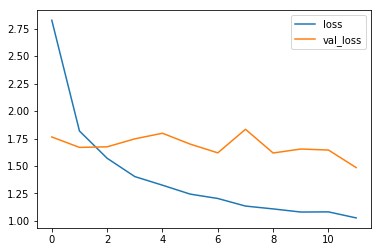

Epoch 13/100
39/39 [==============================] - 196s 5s/step - loss: 1.0076 - categorical_accuracy: 0.6034 - val_loss: 1.5285 - val_categorical_accuracy: 0.5167

Epoch 00013: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00013-1.00763-0.60342-1.52850-0.51667.h5


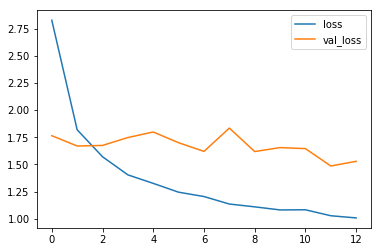

Epoch 14/100
39/39 [==============================] - 195s 5s/step - loss: 0.9831 - categorical_accuracy: 0.6120 - val_loss: 1.3999 - val_categorical_accuracy: 0.5000

Epoch 00014: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00014-0.98315-0.61197-1.39990-0.50000.h5


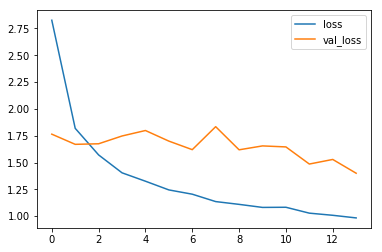

Epoch 15/100
39/39 [==============================] - 194s 5s/step - loss: 0.9819 - categorical_accuracy: 0.6265 - val_loss: 1.6933 - val_categorical_accuracy: 0.5500

Epoch 00015: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00015-0.98192-0.62650-1.69334-0.55000.h5


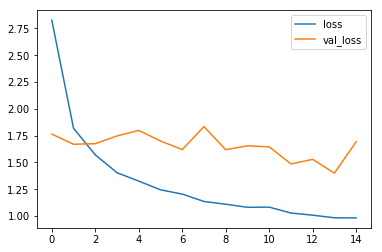

Epoch 16/100
39/39 [==============================] - 194s 5s/step - loss: 0.9445 - categorical_accuracy: 0.6393 - val_loss: 1.4379 - val_categorical_accuracy: 0.5833

Epoch 00016: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00016-0.94453-0.63932-1.43792-0.58333.h5


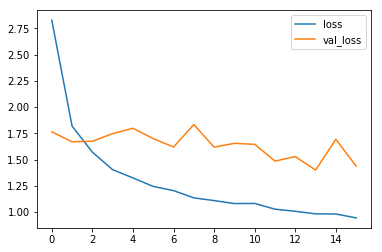

Epoch 17/100
39/39 [==============================] - 194s 5s/step - loss: 0.9714 - categorical_accuracy: 0.6393 - val_loss: 1.4140 - val_categorical_accuracy: 0.5083

Epoch 00017: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00017-0.97135-0.63932-1.41399-0.50833.h5


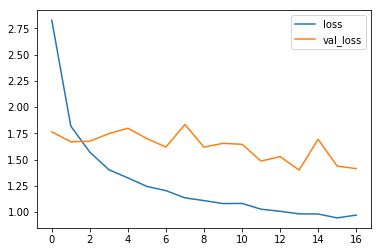

Epoch 18/100
39/39 [==============================] - 194s 5s/step - loss: 0.9190 - categorical_accuracy: 0.6615 - val_loss: 1.4642 - val_categorical_accuracy: 0.5917

Epoch 00018: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00018-0.91902-0.66154-1.46419-0.59167.h5


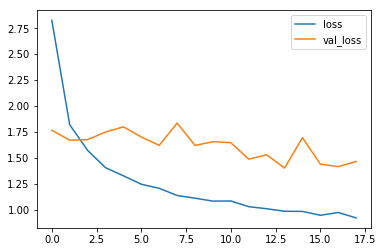

Epoch 19/100
39/39 [==============================] - 195s 5s/step - loss: 0.9034 - categorical_accuracy: 0.6598 - val_loss: 1.3982 - val_categorical_accuracy: 0.6167

Epoch 00019: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00019-0.90336-0.65983-1.39816-0.61667.h5


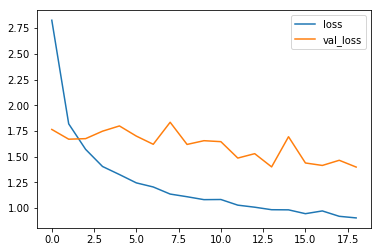

Epoch 20/100
39/39 [==============================] - 193s 5s/step - loss: 0.9061 - categorical_accuracy: 0.6667 - val_loss: 1.5302 - val_categorical_accuracy: 0.5333

Epoch 00020: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00020-0.90610-0.66667-1.53015-0.53333.h5


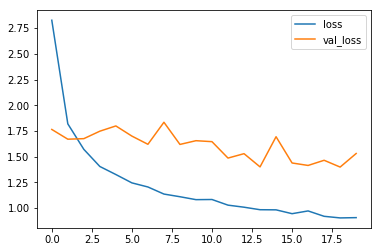

Epoch 21/100
39/39 [==============================] - 195s 5s/step - loss: 0.8870 - categorical_accuracy: 0.6641 - val_loss: 1.4656 - val_categorical_accuracy: 0.5500

Epoch 00021: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00021-0.88704-0.66410-1.46556-0.55000.h5


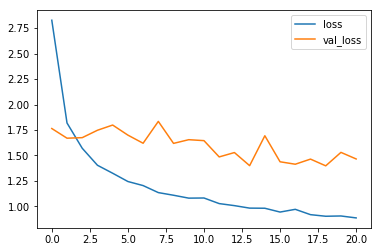

Epoch 22/100
39/39 [==============================] - 194s 5s/step - loss: 0.8643 - categorical_accuracy: 0.6889 - val_loss: 1.5888 - val_categorical_accuracy: 0.5250

Epoch 00022: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00022-0.86431-0.68889-1.58884-0.52500.h5


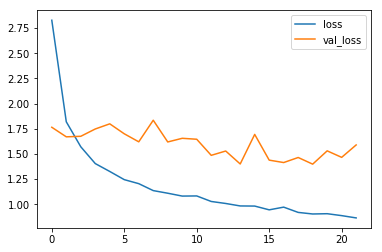

Epoch 23/100
39/39 [==============================] - 193s 5s/step - loss: 0.8429 - categorical_accuracy: 0.7009 - val_loss: 1.6722 - val_categorical_accuracy: 0.5250

Epoch 00023: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00023-0.84293-0.70085-1.67222-0.52500.h5


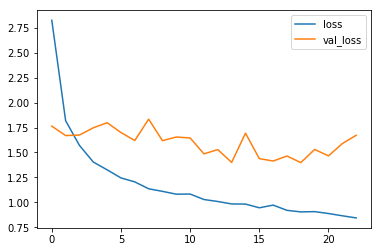

Epoch 24/100
39/39 [==============================] - 197s 5s/step - loss: 0.8204 - categorical_accuracy: 0.7077 - val_loss: 1.2898 - val_categorical_accuracy: 0.6000

Epoch 00024: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00024-0.82036-0.70769-1.28985-0.60000.h5


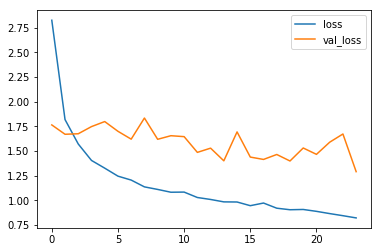

Epoch 25/100
39/39 [==============================] - 195s 5s/step - loss: 0.8476 - categorical_accuracy: 0.7017 - val_loss: 1.5486 - val_categorical_accuracy: 0.5667

Epoch 00025: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00025-0.84760-0.70171-1.54863-0.56667.h5


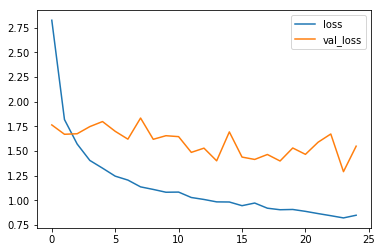

Epoch 26/100
39/39 [==============================] - 196s 5s/step - loss: 0.8547 - categorical_accuracy: 0.6761 - val_loss: 1.4493 - val_categorical_accuracy: 0.5917

Epoch 00026: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00026-0.85469-0.67607-1.44934-0.59167.h5


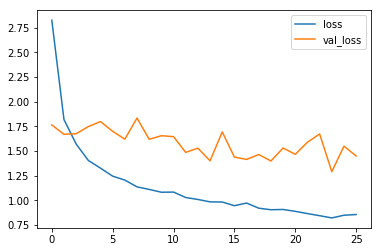

Epoch 27/100
39/39 [==============================] - 195s 5s/step - loss: 0.9066 - categorical_accuracy: 0.6521 - val_loss: 1.3815 - val_categorical_accuracy: 0.6083

Epoch 00027: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00027-0.90664-0.65214-1.38147-0.60833.h5


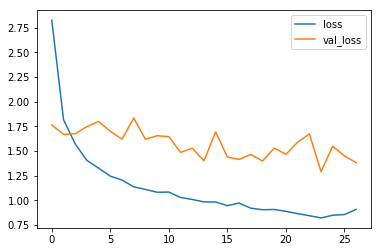

Epoch 28/100
39/39 [==============================] - 195s 5s/step - loss: 0.8301 - categorical_accuracy: 0.7103 - val_loss: 1.7404 - val_categorical_accuracy: 0.5833

Epoch 00028: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00028-0.83007-0.71026-1.74044-0.58333.h5


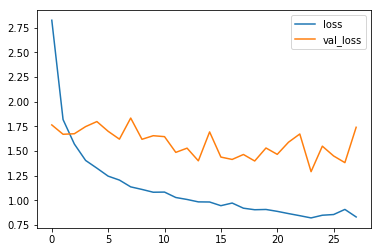

Epoch 29/100
39/39 [==============================] - 195s 5s/step - loss: 0.8165 - categorical_accuracy: 0.6829 - val_loss: 1.4006 - val_categorical_accuracy: 0.6250

Epoch 00029: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00029-0.81650-0.68291-1.40058-0.62500.h5


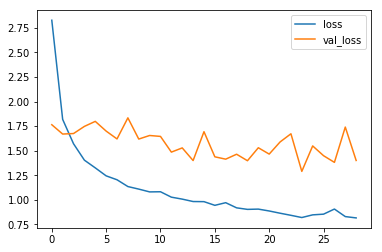

Epoch 30/100
39/39 [==============================] - 197s 5s/step - loss: 0.8156 - categorical_accuracy: 0.6940 - val_loss: 1.5337 - val_categorical_accuracy: 0.5417

Epoch 00030: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00030-0.81557-0.69402-1.53368-0.54167.h5


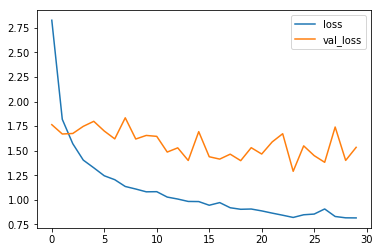

Epoch 31/100
39/39 [==============================] - 197s 5s/step - loss: 0.7927 - categorical_accuracy: 0.7145 - val_loss: 1.5993 - val_categorical_accuracy: 0.5917

Epoch 00031: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00031-0.79271-0.71453-1.59932-0.59167.h5


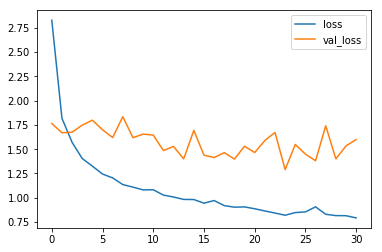

Epoch 32/100
39/39 [==============================] - 195s 5s/step - loss: 0.8255 - categorical_accuracy: 0.7034 - val_loss: 1.6688 - val_categorical_accuracy: 0.5250

Epoch 00032: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00032-0.82554-0.70342-1.66881-0.52500.h5


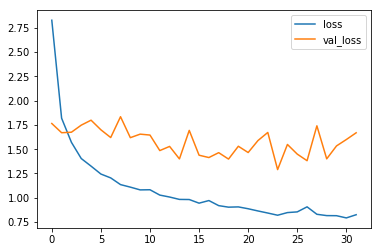

Epoch 33/100
39/39 [==============================] - 194s 5s/step - loss: 0.7976 - categorical_accuracy: 0.7043 - val_loss: 1.5487 - val_categorical_accuracy: 0.5417

Epoch 00033: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00033-0.79757-0.70427-1.54869-0.54167.h5


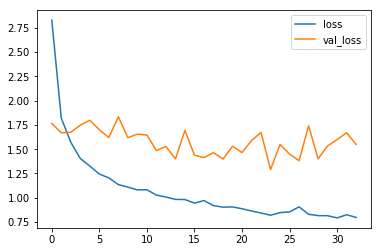

Epoch 34/100
39/39 [==============================] - 195s 5s/step - loss: 0.7883 - categorical_accuracy: 0.7094 - val_loss: 1.4477 - val_categorical_accuracy: 0.5667

Epoch 00034: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00034-0.78826-0.70940-1.44767-0.56667.h5


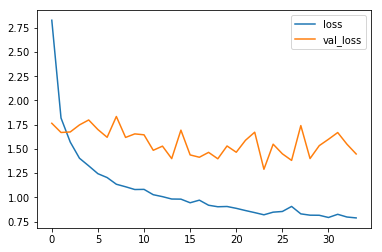

Epoch 35/100
39/39 [==============================] - 195s 5s/step - loss: 0.8094 - categorical_accuracy: 0.7043 - val_loss: 1.6037 - val_categorical_accuracy: 0.5667

Epoch 00035: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00035-0.80943-0.70427-1.60371-0.56667.h5


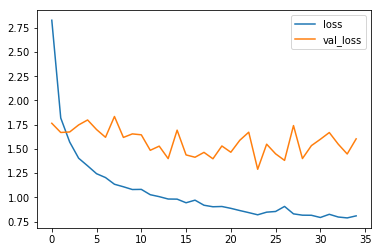

Epoch 36/100
39/39 [==============================] - 195s 5s/step - loss: 0.7942 - categorical_accuracy: 0.7128 - val_loss: 1.7184 - val_categorical_accuracy: 0.5250

Epoch 00036: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00036-0.79425-0.71282-1.71842-0.52500.h5


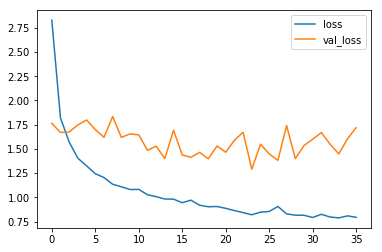

Epoch 37/100
39/39 [==============================] - 195s 5s/step - loss: 0.7965 - categorical_accuracy: 0.7171 - val_loss: 1.8612 - val_categorical_accuracy: 0.5750

Epoch 00037: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00037-0.79645-0.71709-1.86124-0.57500.h5


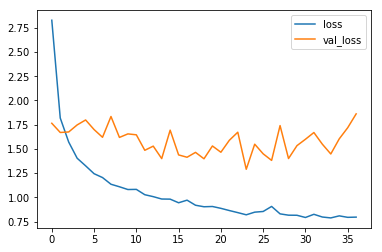

Epoch 38/100
39/39 [==============================] - 195s 5s/step - loss: 0.7781 - categorical_accuracy: 0.6906 - val_loss: 1.4425 - val_categorical_accuracy: 0.5250

Epoch 00038: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00038-0.77811-0.69060-1.44253-0.52500.h5


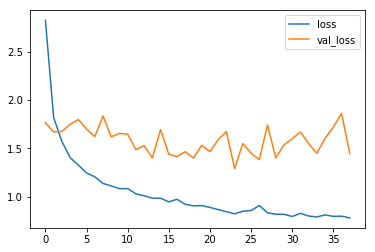

Epoch 39/100
39/39 [==============================] - 195s 5s/step - loss: 0.7813 - categorical_accuracy: 0.7103 - val_loss: 1.8533 - val_categorical_accuracy: 0.5667

Epoch 00039: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00039-0.78127-0.71026-1.85326-0.56667.h5


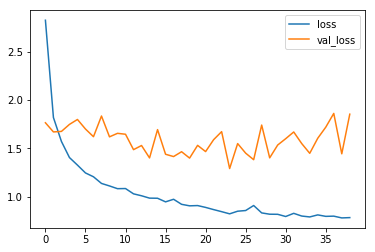

Epoch 40/100
39/39 [==============================] - 196s 5s/step - loss: 0.7974 - categorical_accuracy: 0.7077 - val_loss: 1.4991 - val_categorical_accuracy: 0.5917

Epoch 00040: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00040-0.79742-0.70769-1.49909-0.59167.h5


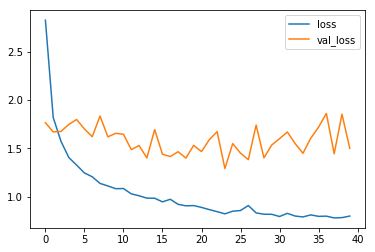

Epoch 41/100
39/39 [==============================] - 195s 5s/step - loss: 0.7853 - categorical_accuracy: 0.7128 - val_loss: 1.5124 - val_categorical_accuracy: 0.6000

Epoch 00041: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00041-0.78532-0.71282-1.51240-0.60000.h5


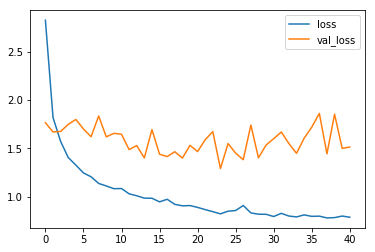

Epoch 42/100
39/39 [==============================] - 195s 5s/step - loss: 0.8255 - categorical_accuracy: 0.7103 - val_loss: 1.5721 - val_categorical_accuracy: 0.5833

Epoch 00042: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00042-0.82552-0.71026-1.57212-0.58333.h5


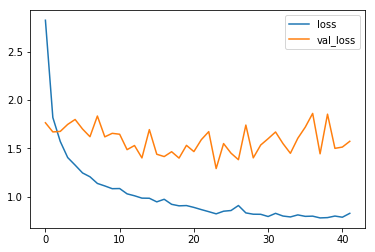

Epoch 43/100
39/39 [==============================] - 196s 5s/step - loss: 0.7940 - categorical_accuracy: 0.7239 - val_loss: 1.4963 - val_categorical_accuracy: 0.5750

Epoch 00043: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00043-0.79400-0.72393-1.49629-0.57500.h5


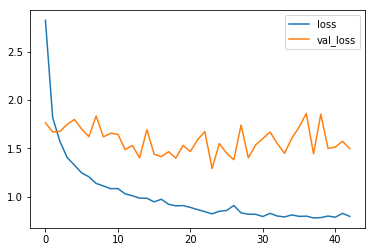

Epoch 44/100
39/39 [==============================] - 196s 5s/step - loss: 0.7878 - categorical_accuracy: 0.7103 - val_loss: 1.7317 - val_categorical_accuracy: 0.5167

Epoch 00044: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00044-0.78777-0.71026-1.73166-0.51667.h5


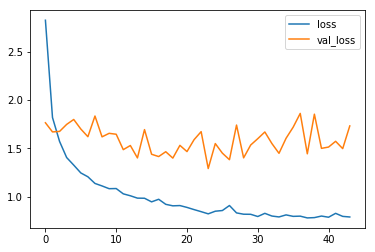

Epoch 45/100
39/39 [==============================] - 195s 5s/step - loss: 0.7857 - categorical_accuracy: 0.7205 - val_loss: 1.6218 - val_categorical_accuracy: 0.6583

Epoch 00045: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00045-0.78570-0.72051-1.62185-0.65833.h5


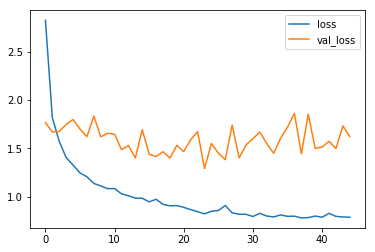

Epoch 46/100
39/39 [==============================] - 196s 5s/step - loss: 0.7998 - categorical_accuracy: 0.7043 - val_loss: 1.5411 - val_categorical_accuracy: 0.5500

Epoch 00046: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00046-0.79978-0.70427-1.54111-0.55000.h5


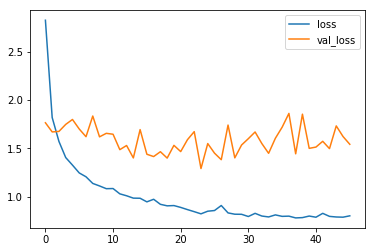

Epoch 47/100
39/39 [==============================] - 195s 5s/step - loss: 0.7224 - categorical_accuracy: 0.7325 - val_loss: 1.7821 - val_categorical_accuracy: 0.4917

Epoch 00047: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00047-0.72235-0.73248-1.78211-0.49167.h5


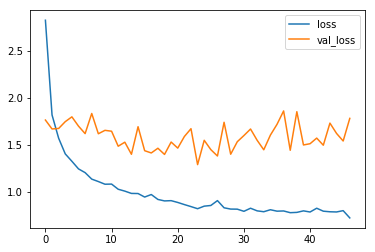

Epoch 48/100
39/39 [==============================] - 195s 5s/step - loss: 0.7787 - categorical_accuracy: 0.7103 - val_loss: 1.3704 - val_categorical_accuracy: 0.6000

Epoch 00048: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00048-0.77868-0.71026-1.37037-0.60000.h5


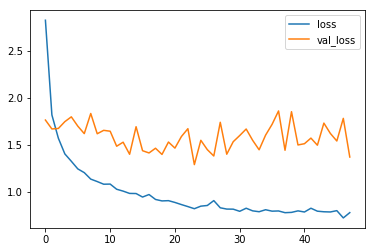

Epoch 49/100
39/39 [==============================] - 194s 5s/step - loss: 0.7865 - categorical_accuracy: 0.7265 - val_loss: 1.3696 - val_categorical_accuracy: 0.6167

Epoch 00049: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00049-0.78647-0.72650-1.36960-0.61667.h5


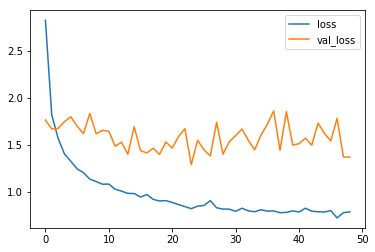

Epoch 50/100
39/39 [==============================] - 194s 5s/step - loss: 0.7863 - categorical_accuracy: 0.7385 - val_loss: 1.8848 - val_categorical_accuracy: 0.5417

Epoch 00050: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00050-0.78632-0.73846-1.88484-0.54167.h5


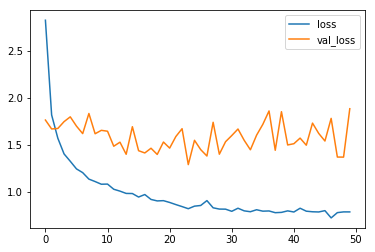

Epoch 51/100
39/39 [==============================] - 194s 5s/step - loss: 0.7396 - categorical_accuracy: 0.7299 - val_loss: 1.5941 - val_categorical_accuracy: 0.5417

Epoch 00051: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00051-0.73957-0.72991-1.59408-0.54167.h5


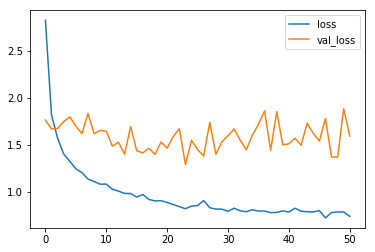

Epoch 52/100
39/39 [==============================] - 194s 5s/step - loss: 0.7610 - categorical_accuracy: 0.7256 - val_loss: 1.5610 - val_categorical_accuracy: 0.5167

Epoch 00052: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00052-0.76096-0.72564-1.56102-0.51667.h5


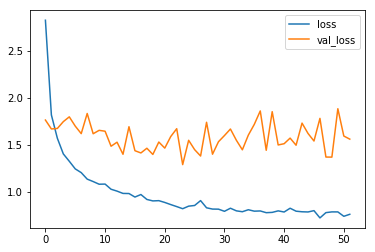

Epoch 53/100
39/39 [==============================] - 196s 5s/step - loss: 0.7886 - categorical_accuracy: 0.7145 - val_loss: 1.7457 - val_categorical_accuracy: 0.5083

Epoch 00053: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00053-0.78864-0.71453-1.74569-0.50833.h5


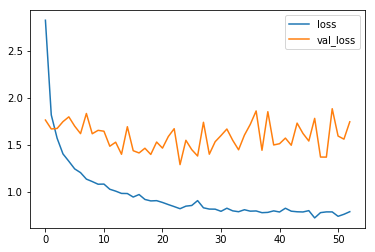

Epoch 54/100
39/39 [==============================] - 197s 5s/step - loss: 0.7369 - categorical_accuracy: 0.7308 - val_loss: 1.4311 - val_categorical_accuracy: 0.5917

Epoch 00054: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00054-0.73685-0.73077-1.43113-0.59167.h5


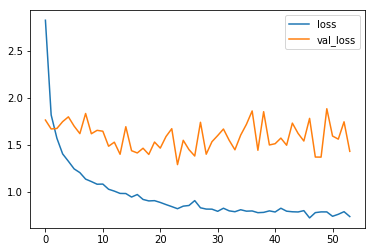

Epoch 55/100
39/39 [==============================] - 196s 5s/step - loss: 0.7400 - categorical_accuracy: 0.7462 - val_loss: 1.4969 - val_categorical_accuracy: 0.6167

Epoch 00055: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00055-0.73997-0.74615-1.49687-0.61667.h5


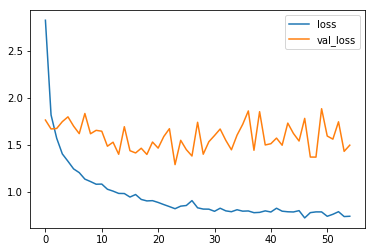

Epoch 56/100
39/39 [==============================] - 196s 5s/step - loss: 0.7511 - categorical_accuracy: 0.7188 - val_loss: 1.4308 - val_categorical_accuracy: 0.6667

Epoch 00056: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00056-0.75112-0.71880-1.43082-0.66667.h5


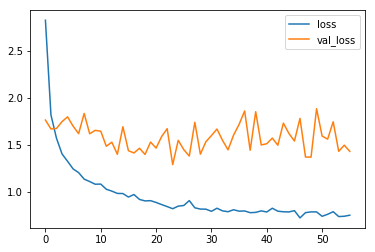

Epoch 57/100
39/39 [==============================] - 195s 5s/step - loss: 0.7280 - categorical_accuracy: 0.7368 - val_loss: 1.7397 - val_categorical_accuracy: 0.6250

Epoch 00057: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00057-0.72803-0.73675-1.73972-0.62500.h5


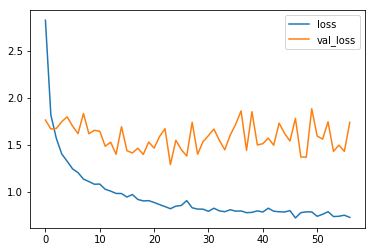

Epoch 58/100
39/39 [==============================] - 195s 5s/step - loss: 0.7585 - categorical_accuracy: 0.7453 - val_loss: 1.6660 - val_categorical_accuracy: 0.5000

Epoch 00058: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00058-0.75853-0.74530-1.66599-0.50000.h5


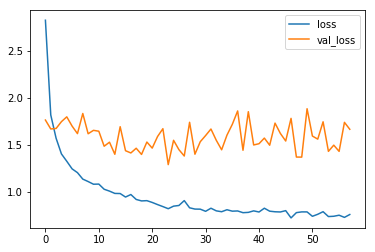

Epoch 59/100
39/39 [==============================] - 196s 5s/step - loss: 0.7358 - categorical_accuracy: 0.7419 - val_loss: 1.5507 - val_categorical_accuracy: 0.6000

Epoch 00059: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00059-0.73582-0.74188-1.55074-0.60000.h5


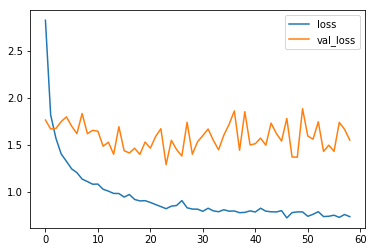

Epoch 60/100
39/39 [==============================] - 195s 5s/step - loss: 0.7354 - categorical_accuracy: 0.7427 - val_loss: 1.5652 - val_categorical_accuracy: 0.6167

Epoch 00060: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00060-0.73539-0.74274-1.56517-0.61667.h5


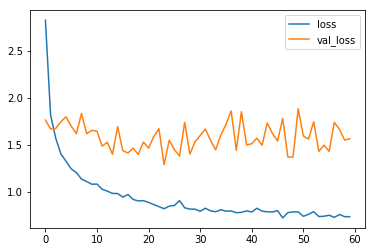

Epoch 61/100
39/39 [==============================] - 196s 5s/step - loss: 0.7552 - categorical_accuracy: 0.7402 - val_loss: 1.4248 - val_categorical_accuracy: 0.6417

Epoch 00061: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00061-0.75523-0.74017-1.42481-0.64167.h5


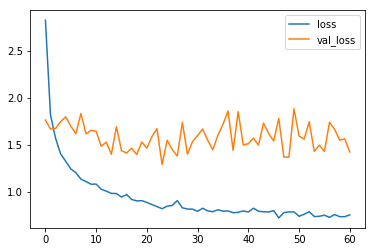

Epoch 62/100
39/39 [==============================] - 196s 5s/step - loss: 0.7236 - categorical_accuracy: 0.7427 - val_loss: 1.6051 - val_categorical_accuracy: 0.5917

Epoch 00062: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00062-0.72356-0.74274-1.60514-0.59167.h5


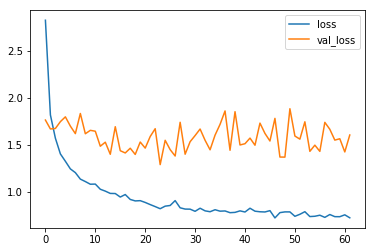

Epoch 63/100
39/39 [==============================] - 195s 5s/step - loss: 0.7373 - categorical_accuracy: 0.7291 - val_loss: 1.1656 - val_categorical_accuracy: 0.6500

Epoch 00063: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00063-0.73730-0.72906-1.16559-0.65000.h5


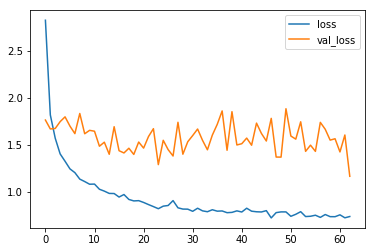

Epoch 64/100
39/39 [==============================] - 196s 5s/step - loss: 0.7298 - categorical_accuracy: 0.7470 - val_loss: 1.4059 - val_categorical_accuracy: 0.6083

Epoch 00064: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00064-0.72981-0.74701-1.40589-0.60833.h5


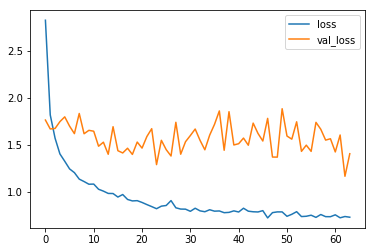

Epoch 65/100
39/39 [==============================] - 196s 5s/step - loss: 0.7585 - categorical_accuracy: 0.7376 - val_loss: 1.6543 - val_categorical_accuracy: 0.5917

Epoch 00065: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00065-0.75854-0.73761-1.65435-0.59167.h5


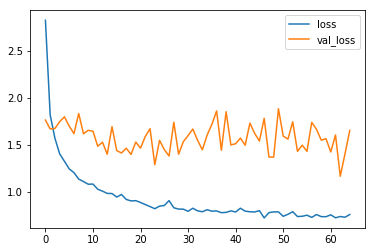

Epoch 66/100
39/39 [==============================] - 195s 5s/step - loss: 0.7490 - categorical_accuracy: 0.7410 - val_loss: 1.5632 - val_categorical_accuracy: 0.5917

Epoch 00066: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00066-0.74901-0.74103-1.56317-0.59167.h5


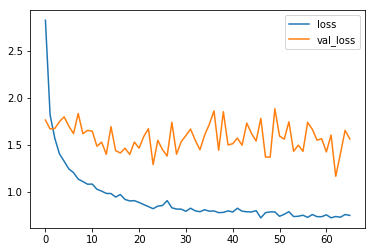

Epoch 67/100
39/39 [==============================] - 196s 5s/step - loss: 0.7249 - categorical_accuracy: 0.7496 - val_loss: 1.6825 - val_categorical_accuracy: 0.6000

Epoch 00067: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00067-0.72491-0.74957-1.68250-0.60000.h5


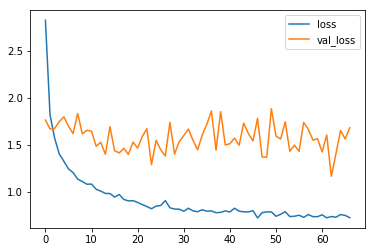

Epoch 68/100
 4/39 [==>...........................] - ETA: 3:14 - loss: 0.6175 - categorical_accuracy: 0.7833

KeyboardInterrupt: 

In [20]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, verbose=1, callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None, workers=1, initial_epoch=0)

#### Traied the Conv3D model for around 65 Epochs and the best accuracy figures are 
##### Epoch 63/100
##### 39/39 [==============================] - 195s 5s/step - loss: 0.7373 - categorical_accuracy: 0.7291 - val_loss: 1.1656 - val_categorical_accuracy: 0.6500

##### Epoch 00063: saving model to C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//model_init_2019-03-2418_26_55.429471//model-00063-0.73730-0.72906-1.16559-0.65000.h5

In [13]:
# This function just produce the counts of various labels 
# in a given data set
def class_count(doc):
    class_count = {'0':0,'1':0,'2':0,'3':0,'4':0}

    for folder in range(len(doc)):
        #print(train_doc[folder])
        cls = int(doc[folder].split(';')[2])
        # Let's count the sequences in each class
        if cls == 0:
            class_count['0'] = class_count.get('0') + 1
        elif cls == 1:
            class_count['1'] = class_count.get('1') + 1
        elif cls == 2:
            class_count['2'] = class_count.get('2') + 1         
        elif cls == 3:
            class_count['3'] = class_count.get('3') + 1
        elif cls == 4:
            class_count['4'] = class_count.get('4') + 1

    print("class_count ", class_count)
    print("total count ", sum(class_count.values()))
    class_weight = [round(v / total, 2) for total in (sum(class_count.values()),) for k, v in class_count.items()]
    print('class_weight', class_weight)

In [11]:
# Lets check the predictions on Test Data
# Test Data comes from augmented dataset  wheer around 
# 80 Videos are reserved i.e. not used for training

val_doc = np.array(open(dir_loc + '//val_bal.csv').readlines())
val_path = dir_loc + '//val_bal'

print(val_doc.shape[0])

80


In [12]:
from keras.models import load_model

model_path = r'C:\Upgrad Projects\DLNN-RNN-M5\GestureRecognition\Project_data\models\model_init_2019-03-2418_26_55.429471\model-00063-0.73730-0.72906-1.16559-0.65000.h5'
conv3d_model = load_model(model_path)

In [13]:
def model_preictions(model, val_doc, val_path):
    from  sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
    # Lets' check how much videos are there for each label
    class_count(val_doc)

    # Initialize Validation generator
    # We will predict for all 80 videos but one video at a time 
    # i.e. batch size = 1
    vid_generator = generator(val_path, val_doc, 1)

    prob_output = []
    predict_output = []

    pred_labels = []
    actual_labels = []
    for v in np.arange(val_doc.shape[0]):
        video, label = next(vid_generator)

        probs = model.predict(video)
        if np.argmax(probs) == np.argmax(label):
            predict_output.append(1)
        else:
            predict_output.append(0)

        pred_labels.append(np.argmax(probs))
        actual_labels.append(np.argmax(label))

        prob_output.append(list(probs))

    con_matrix = confusion_matrix(actual_labels,pred_labels)
    labels = list(set(actual_labels))
    stats_matrix = pd.DataFrame(con_matrix, columns=labels)

    tps = {}
    fps = {}
    fns = {}
    tns = {}
    precision_local = {}
    recall_local = {}
    f1_local = {}
    accuracy_local = {}
    for label in labels:
        tps[label] = stats_matrix.loc[label, label]
        fps[label] = stats_matrix[label].sum() - tps[label]
        fns[label] = stats_matrix.loc[label].sum() - tps[label]
        tns[label] = stats_matrix.sum().sum() - (tps[label] + fps[label] + fns[label])
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]

        precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
        recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
        p, r = precision_local[label], recall_local[label]

        f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
        accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.


    correct_predictions = sum(tps.values())
    total_predictions = stats_matrix.sum().sum()
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0. else 0.

    index = ['tp','fp','fn','tn','precision','recall','f1','accuracy']

    score_matrix = pd.DataFrame([tps,fps,fns,tns,precision_local,recall_local,f1_local,accuracy_local], index=index).T

    #print(score_matrix.sum(axis=0))

    totals = [score_matrix.tp.sum(), score_matrix.fp.sum(),
              score_matrix.fn.sum(), score_matrix.tn.mean(),
              score_matrix.precision.mean(), score_matrix.recall.mean(),
              score_matrix.f1.mean(), score_matrix.accuracy.mean()]
    score_matrix.loc[5] = totals
    index_old = [0,1,2,3,4,5]
    index_new = ['Left Swipe','Right_Swipe','Stop','Thumbs Down','Thumbs Up','avg/total']
    index_dic = dict(zip(index_old, index_new))

    score_matrix = score_matrix.rename(index=index_dic)
    score_matrix[['tp','fp','fn','tn']] = score_matrix[['tp','fp','fn','tn']].astype(int)
    score_matrix[['precision','recall','f1','accuracy']] = score_matrix[['precision','recall','f1','accuracy']].round(2)
    score_matrix['class_count'] = score_matrix['tp'] + score_matrix['fn']

    return score_matrix

In [14]:
score_matrix = model_preictions(conv3d_model, val_doc, val_path)

print("Class Wise Metrics Report ")
score_matrix

class_count  {'0': 16, '1': 16, '2': 16, '3': 16, '4': 16}
total count  80
class_weight [0.2, 0.2, 0.2, 0.2, 0.2]
Source path =  C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//val_bal ; batch size = 1
Class Wise Metrics Report 


,tp,fp,fn,tn,precision,recall,f1,accuracy,class_count
Left Swipe,8,4,8,60,0.67,0.50,0.57,0.40,16
Right_Swipe,6,9,10,55,0.40,0.38,0.39,0.24,16
Stop,10,10,6,54,0.50,0.62,0.56,0.38,16
Thumbs Down,13,7,3,57,0.65,0.81,0.72,0.57,16
Thumbs Up,9,4,7,60,0.69,0.56,0.62,0.45,16
avg/total,46,34,34,57,0.58,0.57,0.57,0.41,80


##### Let's build another model using Transfer learning - Resnet Pre Trained

In [14]:
# Let's use different generator function
def resnet_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    # Ignoring firt 5 and last 5 images. 
    img_idx = [ele for ele in range(5, 25, 1)]   
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = t.shape[0]//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x, y, z = len(img_idx), 224, 224
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = imresize(image, (224, 224,3))
                    image = preprocess_img(image)


                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches           
        rem_batch_size = t.shape[0] % batch_size
        if rem_batch_size > 0:
            batch = num_batches + 1
            for folder in range(rem_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*rem_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*rem_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    image = imresize(image, (224, 224,3))
                    image = preprocess_img(image)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0

                batch_labels[folder, int(t[folder + (batch*rem_batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield


In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU,LSTM, Flatten, TimeDistributed,RepeatVector,MaxPooling2D, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import scipy.misc
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
# import libraries
import os
import shutil
import numpy as np
import glob   
import keras.backend as K
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import scipy.misc
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [16]:
# number of classes 
num_classes = 5
n_cells = 5
#number of neurons to add in the hidden layer
time_steps = 30
features = 224
frames = 20
channels = 3
rows = 224
columns=224
classes =5
output_activation = 'softmax'

def get_model():
    
    # Get base model: ResNet50 
    video = Input(shape=(frames,
                     rows,
                     columns,channels))
    
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Get the output from the base model 
    cnn_out = GlobalAveragePooling2D()(base_model.output)
    
    cnn = Model(input=base_model.input, output=cnn_out)
    cnn.trainable = False
    encoded_frames = TimeDistributed(cnn)(video)
    #LSTM to be changed to GRU to make training faster
    encoded_sequence = LSTM(128)(encoded_frames)
    hidden_layer = Dense(output_dim=512, activation="relu")(encoded_sequence)
    #batch_norm = BatchNormalization()(hidden_layer)
    outputs = Dense(output_dim=classes, activation="softmax")(hidden_layer)
    model = Model([video], outputs)
           
    return model

In [17]:
# Get the model
model = get_model()

#model.add(LSTM(n_cells, input_shape=(time_steps, features)))
optimiser = optimizers.SGD(lr=0.01, clipnorm=1.0, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 224, 224, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2048)          23587712  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               1114624   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 24,770,949
Trainable params: 1,183,237
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
batch_size = 30

In [19]:
val_path

'C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//val'

In [20]:
# Let's initialize generators
train_generator = resnet_generator(train_path, train_doc, batch_size)

val_generator = resnet_generator(val_path, val_doc, batch_size)

In [21]:
model_name = dir_loc + '//models//resnet//model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '//'
print(model_name) 

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.001)
#callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint, LR, plot_losses]

C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//resnet//model_init_2019-03-2423_49_36.312216//
C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//models//resnet//model_init_2019-03-2423_49_36.312216//model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5


In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
print(steps_per_epoch)
print(validation_steps)    

39
4


In [23]:
class_count(train_doc)

class_count  {'0': 230, '1': 230, '2': 230, '3': 230, '4': 230}
total count  1150
class_weight [0.2, 0.2, 0.2, 0.2, 0.2]


##### Resnet Fit Generator

In [24]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
Source path =  C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//val ; batch size = 30
Source path =  C://Upgrad Projects//DLNN-RNN-M5//GestureRecognition//Project_data//train_bal ; batch size = 30


KeyboardInterrupt: 

<Figure size 288x288 with 0 Axes>

In [ ]:
### Due to Resource issue - Not able to run Resnet model again.
### Earlier run had good accuracy.